In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [16]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)
K = len(np.unique(y_train)) # Return the unique elements of a tratining output set and take it length as Classes
Ntr = x_train.shape[0] # number of training examples
Nte = x_test.shape[0] # number of testing examples
Din = 3072 # By CIFAR10 data set with 32 x 32 x 3 color images

x_train = x_train[range(Ntr), :]
x_test = x_test[range(Nte), :]
y_train = y_train[range(Ntr)]
y_test = y_test[range(Nte)]


y_train = tf.keras.utils.to_categorical(y_train, num_classes=K) # This function returns a matrix of binary values (either ‘1’ or ‘0’). It has number of rows equal to the length of the input vector and number of columns equal to the number of classes.
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)
x_train = np.reshape(x_train,(Ntr,Din)).astype('float32') # reshape the data set
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')

#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

H = 200 # No of hidden nodes
std=1e-6 # standard deviation (sigma)
w1 = std*np.random.randn(Din, H) #Return a sample (or samples) from the “standard normal” distribution.
w2 = std*np.random.randn(H, K)
b1 = np.zeros(H) # creating array of zeros
b2 = np.zeros(K)
print("w1:", w1.shape)
print("w2:", w2.shape)
print("b1:", b1.shape)
print("b2:", b2.shape)

x_train: (50000, 32, 32, 3)
w1: (3072, 200)
w2: (200, 10)
b1: (200,)
b2: (10,)


## For gradient descent

In [17]:
batch_size1 = Ntr # for gradient descent optimization batch size is equal to number of training set

iterations = 300 # epochs
lr = 1.4e-2 # the learning rate alpha
lr_decay = 0.999
reg = 5e-6 # the regularization constant
loss_history1 = []
train_acc_history1 = []
val_acc_history1 = []
lr_history1 = []

for t in range(iterations):
    batch_indices = np.random.choice(Ntr, batch_size1)
    x = x_train[batch_indices]
    y = y_train[batch_indices]
    #forward
    #----------------------------------------------for train set---------------------------------------------------------------------
    h = 1.0/(1.0 + np.exp(-(x.dot(w1) + b1 ))) # create a activation function (sigmoid function)
    y_pred = h.dot(w2) + b2 # create predictable output
    #----------------------------------------------for test set----------------------------------------------------------------------
    h_t = 1.0/(1.0 + np.exp(-(x_test.dot(w1) + b1 ))) # create a activation function for test data (sigmoid function)
    y_pred_test = h_t.dot(w2) + b2 # create predictable output
    #--------------------------------------------------------------------------------------------------------------------------------
    loss = (1./batch_size1)*np.square(y_pred - y).sum() + reg*(np.sum(w2*w2) + np.sum(w1*w1)) # loss function with regularization term 
    loss_history1.append(loss)
    
    # compute the accuracy as percentage
    training_acc = 100*(1 - (1/(batch_size1*K))*(np.abs(np.argmax(y,axis=1) - np.argmax(y_pred,axis=1))).sum())  
    testing_acc = 100*(1 - (1/(Nte*K))*(np.abs(np.argmax(y_test,axis=1) - np.argmax(y_pred_test,axis=1))).sum())
    train_acc_history1.append(training_acc)
    val_acc_history1.append(testing_acc)
    
    if t % 10 == 0:
        print("iteration %d / %d| loss %f| training accuracy %f| testing accuracy %f" % (t, iterations, loss, training_acc, testing_acc))
    #backward
    dy_pred = 1./batch_size1*2.0*(y_pred - y) # partial derivatives w.r.t y_predicted
    dw2 = h.T.dot(dy_pred) + reg*w2
    db2 = dy_pred.sum(axis=0)
    dh = dy_pred.dot(w2.T)
    dw1 = x.T.dot(dh*h*(1-h)) + reg*w1
    db1 = (dh*h*(1-h)).sum(axis=0)

    # updating learning parameters
    w1 -= lr*dw1
    w2 -= lr*dw2
    b1 -= lr*db1
    b2 -= lr*db2
    lr *= lr_decay
    
    lr_history1.append(lr)

iteration 0 / 300| loss 0.999993| training accuracy 55.098800| testing accuracy 55.000000
iteration 10 / 300| loss 0.905650| training accuracy 72.206400| testing accuracy 72.282000
iteration 20 / 300| loss 0.860422| training accuracy 70.209800| testing accuracy 70.070000
iteration 30 / 300| loss 0.839988| training accuracy 72.827200| testing accuracy 72.625000
iteration 40 / 300| loss 0.830831| training accuracy 73.267800| testing accuracy 73.022000
iteration 50 / 300| loss 0.824713| training accuracy 74.016000| testing accuracy 74.202000
iteration 60 / 300| loss 0.814472| training accuracy 75.100600| testing accuracy 75.008000
iteration 70 / 300| loss 0.807319| training accuracy 76.010200| testing accuracy 75.890000
iteration 80 / 300| loss 0.813216| training accuracy 75.616000| testing accuracy 75.537000
iteration 90 / 300| loss 0.800282| training accuracy 76.725600| testing accuracy 76.665000
iteration 100 / 300| loss 0.792306| training accuracy 76.795000| testing accuracy 76.687000

## for stochastic gradient descent

In [12]:
batch_size = 500 # for gradient descent optimization batch size is equal to number of training set

iterations = 300 # epochs
lr = 1.4e-2 # the learning rate alpha
lr_decay = 0.999
reg = 5e-6 # the regularization constant
loss_history = []
train_acc_history = []
val_acc_history = []
lr_history = []

for t in range(iterations):
    
    for start in range(0, Ntr, batch_size):
        batch_indices = np.random.choice(Ntr, batch_size)
        x = x_train[batch_indices]
        y = y_train[batch_indices]
        
        #forward
        #----------------------------------------------for train set---------------------------------------------------------------------
        h = 1.0/(1.0 + np.exp(-(x.dot(w1) + b1 ))) # create a activation function (sigmoid function)
        y_pred = h.dot(w2) + b2 # create predictable output
        #----------------------------------------------for test set----------------------------------------------------------------------
        h_t = 1.0/(1.0 + np.exp(-(x_test.dot(w1) + b1 ))) # create a activation function for test data (sigmoid function)
        y_pred_test = h_t.dot(w2) + b2 # create predictable output
        #--------------------------------------------------------------------------------------------------------------------------------
        loss = (1./(y_pred.shape[0]))*np.square(y_pred - y).sum() + reg*(np.sum(w2*w2) + np.sum(w1*w1)) # loss function with regularization term 
        
    
        # compute the accuracy as percentage
        training_acc = 100*(1 - (1/((y_pred.shape[0])*K))*(np.abs(np.argmax(y,axis=1) - np.argmax(y_pred,axis=1))).sum())  
        testing_acc = 100*(1 - (1/((y_pred_test.shape[0])*K))*(np.abs(np.argmax(y_test,axis=1) - np.argmax(y_pred_test,axis=1))).sum())
        
        
        #backward
        dy_pred = 1./batch_size*2.0*(y_pred - y) # partial derivatives w.r.t y_predicted
        dw2 = h.T.dot(dy_pred) + reg*w2
        db2 = dy_pred.sum(axis=0)
        dh = dy_pred.dot(w2.T)
        dw1 = x.T.dot(dh*h*(1-h)) + reg*w1
        db1 = (dh*h*(1-h)).sum(axis=0)

        # updating learning parameters
        w1 -= lr*dw1
        w2 -= lr*dw2
        b1 -= lr*db1
        b2 -= lr*db2
        lr *= lr_decay
        
    train_acc_history.append(training_acc)
    val_acc_history.append(testing_acc)
    loss_history.append(loss)
    lr_history.append(lr)
    
    if t % 1 == 0:
            print("iteration %d / %d| loss %f| training accuracy %f| testing accuracy %f" % (t, iterations, loss, training_acc, testing_acc))
        
        
        

iteration 0 / 300| loss 0.788353| training accuracy 76.620000| testing accuracy 77.302000
iteration 1 / 300| loss 0.758802| training accuracy 78.340000| testing accuracy 78.896000
iteration 2 / 300| loss 0.742333| training accuracy 79.800000| testing accuracy 78.361000
iteration 3 / 300| loss 0.718920| training accuracy 79.880000| testing accuracy 79.020000
iteration 4 / 300| loss 0.738483| training accuracy 81.060000| testing accuracy 78.551000
iteration 5 / 300| loss 0.715780| training accuracy 78.920000| testing accuracy 79.162000
iteration 6 / 300| loss 0.725018| training accuracy 80.780000| testing accuracy 79.293000
iteration 7 / 300| loss 0.704406| training accuracy 80.660000| testing accuracy 79.485000
iteration 8 / 300| loss 0.703093| training accuracy 82.780000| testing accuracy 79.408000
iteration 9 / 300| loss 0.687295| training accuracy 81.440000| testing accuracy 79.235000
iteration 10 / 300| loss 0.688288| training accuracy 81.860000| testing accuracy 79.338000
iteration

In [19]:
sgd_loss_history = loss_history
sgd_train_acc_history = train_acc_history
sgd_val_acc_history = val_acc_history
sgd_lr_history = lr_history

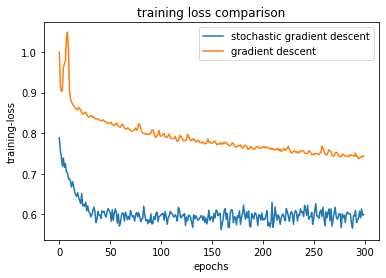

In [23]:
fig, axes = plt.subplots()
axes.plot(sgd_loss_history)  
axes.plot(loss_history1)  
plt.legend(["stochastic gradient descent", "gradient descent"])
axes.set_xlabel("epochs")
axes.set_ylabel("training-loss")
axes.set_title("training loss comparison")
plt.show()
fig.savefig('training_loss_comparison.png',transparent=True)

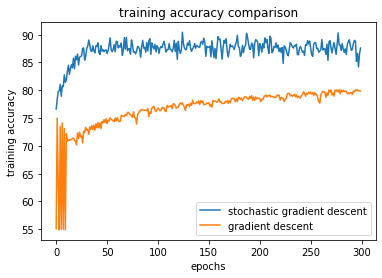

In [24]:
fig, axes = plt.subplots()
axes.plot(sgd_train_acc_history)  
axes.plot(train_acc_history1)  
plt.legend(["stochastic gradient descent", "gradient descent"])
axes.set_xlabel("epochs")
axes.set_ylabel("training accuracy")
axes.set_title("training accuracy comparison")
plt.show()
fig.savefig('training_accuracy_comparison.png',transparent=True)

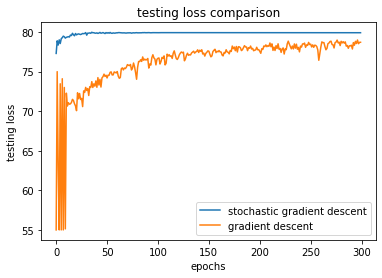

In [25]:
fig, axes = plt.subplots()
axes.plot(sgd_val_acc_history)  
axes.plot(val_acc_history1)  
plt.legend(["stochastic gradient descent", "gradient descent"])
axes.set_xlabel("epochs")
axes.set_ylabel("testing loss")
axes.set_title("testing loss comparison")
plt.show()
fig.savefig('testing_loss_comparison.png',transparent=True)

In [ ]:
fig, axes = plt.subplots()
axes.plot(sgd_loss_history)  
axes.plot(loss_history1)  
plt.legend(["stochastic gradient descent", "gradient descent"])
axes.set_xlabel("epochs")
axes.set_ylabel("training-loss")
axes.set_title("training-loss_comparison")
plt.show()
fig.savefig('training-loss_comparison.png',transparent=True)

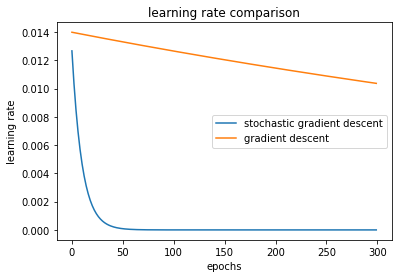

In [26]:
fig, axes = plt.subplots()
axes.plot(sgd_lr_history)  
axes.plot(lr_history1)  
plt.legend(["stochastic gradient descent", "gradient descent"])
axes.set_xlabel("epochs")
axes.set_ylabel("learning rate")
axes.set_title("learning rate comparison")
plt.show()
fig.savefig('learning_rate_comparison.png',transparent=True)